# import Lbibraries

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import plotly.express as px
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from catboost import CatBoostClassifier, Pool
import shap
from lime.lime_tabular import LimeTabularExplainer
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

import warnings
warnings.filterwarnings("ignore")

# Read the data

In [3]:
data = pd.read_csv('Loan.csv')

In [4]:
data.head()

,ApplicationDate,Age,AnnualIncome,CreditScore,EmploymentStatus,EducationLevel,Experience,LoanAmount,LoanDuration,MaritalStatus,...,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,2018-01-01,45,39948,617,Employed,Master,22,13152,48,Married,...,3329.000000,0.724972,11,126928,0.199652,0.227590,419.805992,0.181077,0,49.0
1,2018-01-02,38,39709,628,Employed,Associate,15,26045,48,Single,...,3309.083333,0.935132,3,43609,0.207045,0.201077,794.054238,0.389852,0,52.0
2,2018-01-03,47,40724,570,Employed,Bachelor,26,17627,36,Married,...,3393.666667,0.872241,6,5205,0.217627,0.212548,666.406688,0.462157,0,52.0
3,2018-01-04,58,69084,545,Employed,High School,34,37898,96,Single,...,5757.000000,0.896155,5,99452,0.300398,0.300911,1047.506980,0.313098,0,54.0
4,2018-01-05,37,103264,594,Employed,Associate,17,9184,36,Married,...,8605.333333,0.941369,5,227019,0.197184,0.175990,330.179140,0.070210,1,36.0


In [5]:
data.shape

(20000, 36)

In [6]:
data.drop(columns=['ApplicationDate', 'RiskScore'], inplace=True)

In [7]:
data.shape

(20000, 34)

## Data Preprocessing

In [8]:
numerical_features = [
    'Age', 
    'AnnualIncome', 
    'CreditScore',
    'Experience',
    'LoanAmount',
    'LoanDuration',
    'NumberOfDependents',
    'MonthlyDebtPayments',
    'CreditCardUtilizationRate',
    'NumberOfOpenCreditLines',
    'NumberOfCreditInquiries',
    'DebtToIncomeRatio',
    'BankruptcyHistory',
    'PreviousLoanDefaults',
    'PaymentHistory',
    'LengthOfCreditHistory',
    'SavingsAccountBalance',
    'CheckingAccountBalance',
    'TotalAssets',
    'TotalLiabilities',
    'MonthlyIncome',
    'UtilityBillsPaymentHistory',
    'JobTenure',
    'NetWorth',
    'BaseInterestRate',
    'InterestRate',
    'MonthlyLoanPayment',
    'TotalDebtToIncomeRatio'
]
print(f'Number of numerical features: {len(numerical_features)}')

Number of numerical features: 28


In [9]:
categorical_features = [
    'EmploymentStatus',
    'EducationLevel',
    'MaritalStatus',
    'HomeOwnershipStatus',
    'LoanPurpose'
]
print(f'Number of categorical features: {len(categorical_features)}')

Number of categorical features: 5


In [11]:
X = data.drop(columns='LoanApproved')
y = data['LoanApproved']

In [12]:
X.head()

,Age,AnnualIncome,CreditScore,EmploymentStatus,EducationLevel,Experience,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,...,TotalAssets,TotalLiabilities,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio
0,45,39948,617,Employed,Master,22,13152,48,Married,2,...,146111,19183,3329.000000,0.724972,11,126928,0.199652,0.227590,419.805992,0.181077
1,38,39709,628,Employed,Associate,15,26045,48,Single,1,...,53204,9595,3309.083333,0.935132,3,43609,0.207045,0.201077,794.054238,0.389852
2,47,40724,570,Employed,Bachelor,26,17627,36,Married,2,...,25176,128874,3393.666667,0.872241,6,5205,0.217627,0.212548,666.406688,0.462157
3,58,69084,545,Employed,High School,34,37898,96,Single,1,...,104822,5370,5757.000000,0.896155,5,99452,0.300398,0.300911,1047.506980,0.313098
4,37,103264,594,Employed,Associate,17,9184,36,Married,1,...,244305,17286,8605.333333,0.941369,5,227019,0.197184,0.175990,330.179140,0.070210


In [13]:
X.shape

(20000, 33)

In [14]:
y.shape

(20000,)

In [15]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [16]:
categorical_indices = [X.columns.get_loc(col) for col in categorical_features]

## Fitting the Classifier using GridSearch Cross Validation

In [17]:
model = CatBoostClassifier(cat_features=categorical_indices, random_seed=42, verbose=False)

In [18]:
param_grid = {
    'iterations': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 8]
}

In [19]:
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

In [20]:
grid_search.fit(X_dev, y_dev)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ........depth=4, iterations=100, learning_rate=0.01; total time=   2.6s
[CV] END ........depth=4, iterations=100, learning_rate=0.01; total time=   2.6s
[CV] END ........depth=4, iterations=100, learning_rate=0.01; total time=   2.7s
[CV] END .........depth=4, iterations=100, learning_rate=0.1; total time=   2.7s
[CV] END ........depth=4, iterations=100, learning_rate=0.01; total time=   2.7s
[CV] END ........depth=4, iterations=100, learning_rate=0.01; total time=   2.7s
[CV] END .........depth=4, iterations=100, learning_rate=0.1; total time=   2.8s
[CV] END .........depth=4, iterations=100, learning_rate=0.1; total time=   2.7s
[CV] END .........depth=4, iterations=100, learning_rate=0.1; total time=   2.7s
[CV] END .........depth=4, iterations=100, learning_rate=0.1; total time=   2.7s
[CV] END .........depth=4, iterations=100, learning_rate=0.2; total time=   2.8s
[CV] END .........depth=4, iterations=100, learn

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x17cfeace0>,
             n_jobs=-1,
             param_grid={'depth': [4, 6, 8], 'iterations': [100, 200],
                         'learning_rate': [0.01, 0.1, 0.2]},
             scoring='accuracy', verbose=2)

In [21]:
best_model = grid_search.best_estimator_
print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.2f}")


Best Parameters: {'depth': 4, 'iterations': 200, 'learning_rate': 0.2}
Best Cross-Validation Accuracy: 0.96


## Evaluation

In [22]:
y_pred_best = best_model.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"\nTest Accuracy of Best Model: {accuracy_best:.2f}")
print("\nClassification Report for Best Model:")
print(classification_report(y_test, y_pred_best))


Test Accuracy of Best Model: 0.97

Classification Report for Best Model:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3044
           1       0.94      0.92      0.93       956

    accuracy                           0.97      4000
   macro avg       0.96      0.95      0.95      4000
weighted avg       0.97      0.97      0.97      4000



In [ ]:
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
auroc = roc_auc_score(y_test, y_pred_proba)
print(f"AUROC: {auroc}")

## Model Interpretability

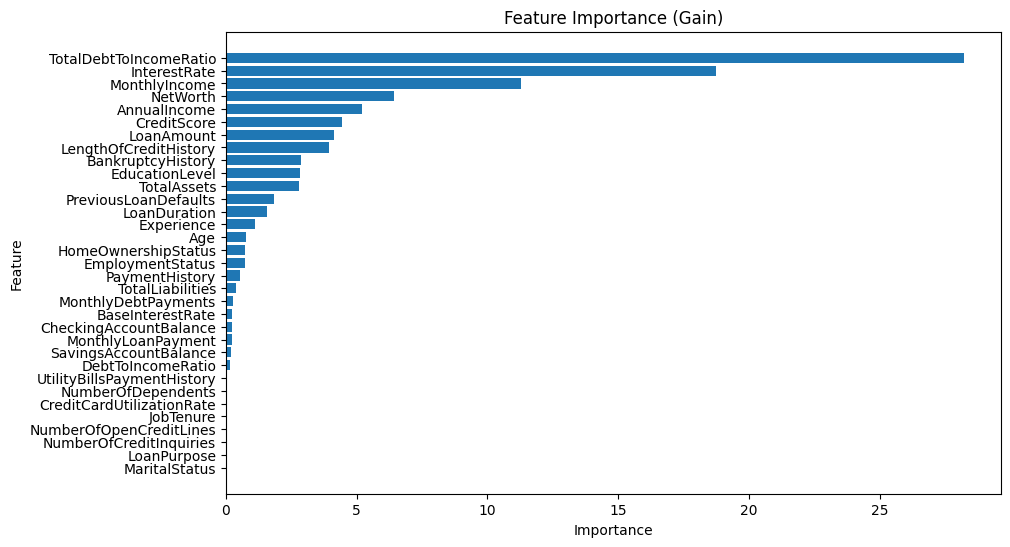

In [27]:
feature_importances = best_model.get_feature_importance(type='FeatureImportance')
feature_names = X_dev.columns

feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (Gain)')
plt.gca().invert_yaxis()
plt.show()

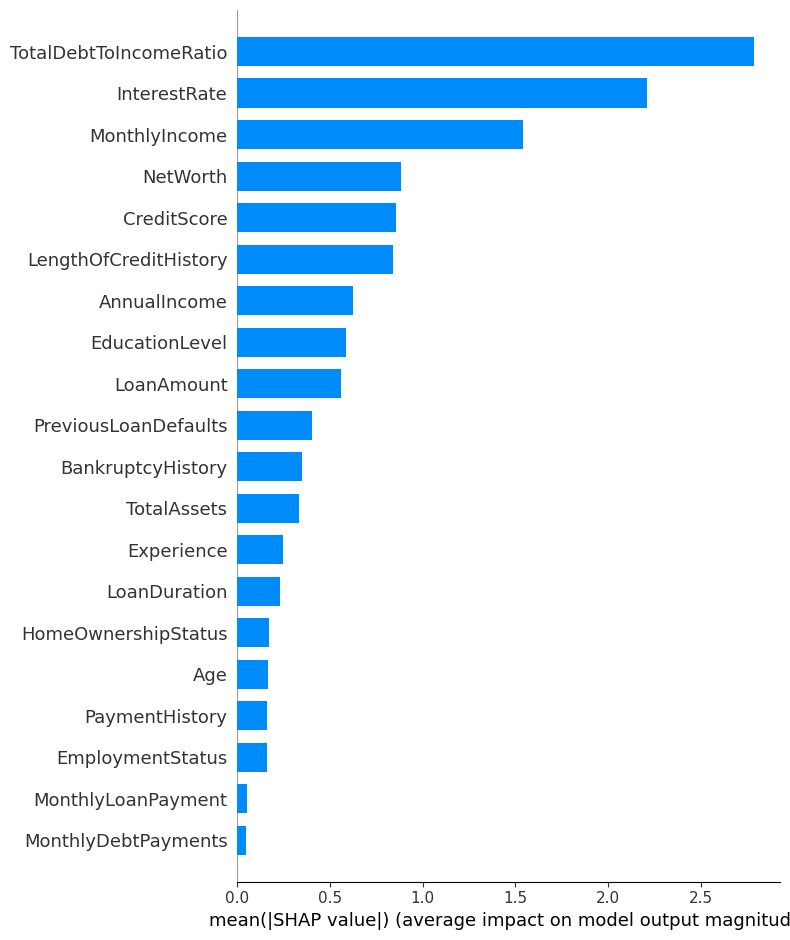

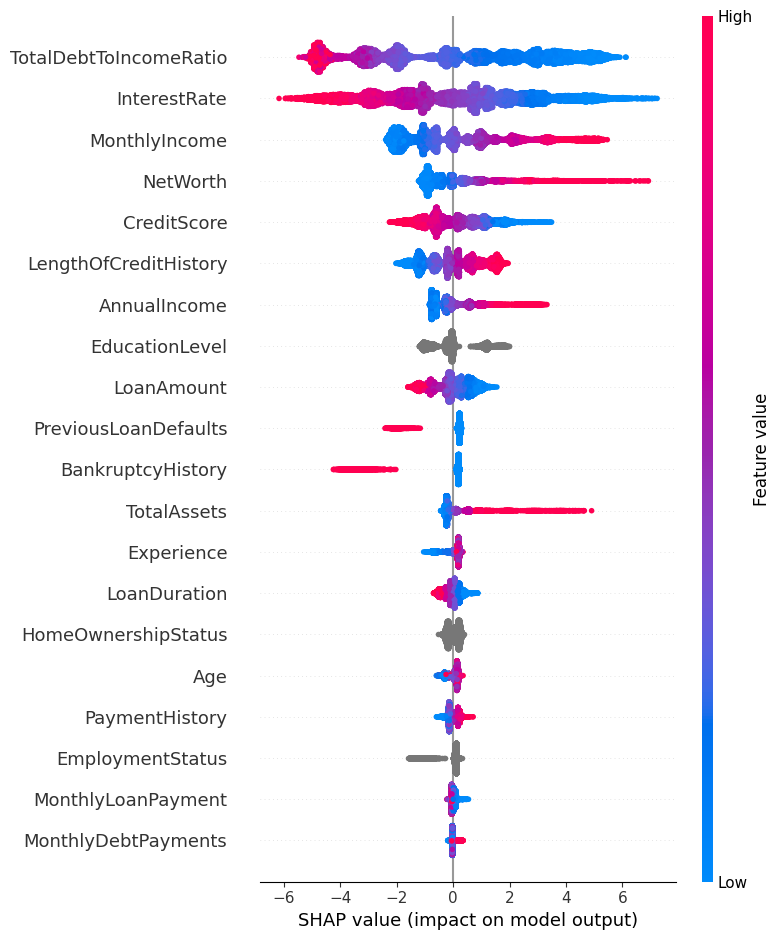

In [28]:
# Prepare SHAP values
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_dev)

# Summary plot
shap.summary_plot(shap_values, X_dev, plot_type='bar')  # Global feature importance
shap.summary_plot(shap_values, X_dev)  # Detailed summary

# Force plot for individual prediction
i = 0  # Index of the instance
shap.force_plot(explainer.expected_value, shap_values[i], X_dev.iloc[i])